In [1]:
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
import imageio

OUTPUT_WIDTH = 320
MAX_ITER = 250

In [2]:
def escapes(x, y, max_iter):
    p = complex(0, 0)
    c = complex(x, y)
    for i in xrange(max_iter):
        p = p*p + c
        if abs(p) > 2:
            return i
    return -1

escapes = np.vectorize(escapes)

print escapes(0, 0, 100)
print escapes(1, 0, 100)

-1
2


In [3]:
%matplotlib inline 

class Mandelbrot(object):
    def __init__(self, img_width, max_iter=100):
        self.width = img_width
        self.height = int(img_width / 1.75) # 1.75 keeps the aspect ratio (c.f. xcoords, ycoords) 
        self.reset_window()
        self.max_iter = max_iter
    def render(self, renderer):
        xx,yy = np.meshgrid(self.xcoords, self.ycoords)
        z = escapes(xx, yy, self.max_iter)
        img = renderer.process(z)
        return img
    def zoom(self, factor):
        f = 1. / factor
        xrng = self.xcoords[-1] - self.xcoords[0]
        yrng = self.ycoords[-1] - self.ycoords[0]
        cx = self.xcoords[0] + 0.5 * xrng
        cy = self.ycoords[0] + 0.5 * yrng
        dx = 0.5 * f * xrng
        dy = 0.5 * f * yrng
        self.set_window(cx - dx, cx + dx, cy - dy, cy + dy)    
    def animate(self, x, y, zoom, n_frames, renderer, outfile, fps=30):
        dx = 3.5
        dy = 2
        self.set_window(x - dx, x + dx, y - dy, y + dy, reshape=True)
        
        def next_frame():
            self.zoom(zoom)
            img = self.render(renderer)
            img *= 255
            return img.astype('uint8')
        
        writer = imageio.save(outfile, fps=fps, palettesize=256)
        for i in xrange(n_frames):
            frame = next_frame()
            writer.append_data(frame)
            
    def set_window(self, xmin, xmax, ymin, ymax, reshape=False):
        self.xcoords = np.linspace(xmin, xmax, self.width)
        if reshape:
            self.height = int(self.width / (xmax - xmin) * (ymax - ymin))
        self.ycoords = np.linspace(ymin, ymax, self.height)
    def reset_window(self):
        self.set_window(-2.5, 1.0, -1.0, 1.0)

class Renderer(object):
    def __init__(self):
        pass
    def process(self, image):
        raise Exception("Use implementing subclass.")

class BinaryRenderer(Renderer):
    def __init__(self):
        super(BinaryRenderer, self).__init__()
        self.n = 1
    def process(self, z):
        return z != -1

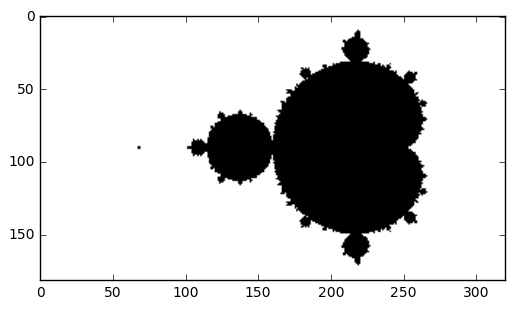

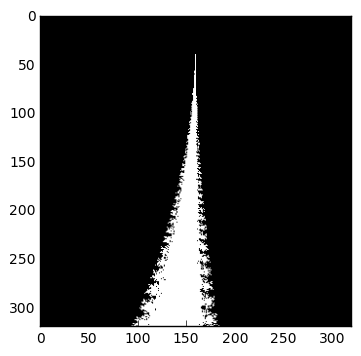

In [4]:
m = Mandelbrot(OUTPUT_WIDTH, max_iter=MAX_ITER)

br = BinaryRenderer()
img = m.render(br)
plt.imshow(img, cmap='gray')
plt.show()

m.set_window(-0.8, -0.7, 0, 0.1, reshape=True)
img = m.render(br)
plt.imshow(img, cmap='gray')
plt.show()

In [5]:
class LinearGradientRenderer(Renderer):
    def __init__(self, color_from, color_to, n_colors):
        super(LinearGradientRenderer, self).__init__()
        self.col1 = color_from
        self.col2 = color_to
        self.n = n_colors
        self.colors = np.vstack((
            np.linspace(self.col1[0], self.col2[0], self.n),
            np.linspace(self.col1[1], self.col2[1], self.n),
            np.linspace(self.col1[2], self.col2[2], self.n),
        ))
    def process(self, z):               
        def colorize(val):
            if val == -1:
                return np.zeros(3)
            else:
                return self.colors[:,val]
                
        img = np.zeros(z.shape + (3,))
        for y in xrange(img.shape[0]):
            for x in xrange(img.shape[1]):
                img[y,x,:] = colorize(z[y,x])        
        
        return img

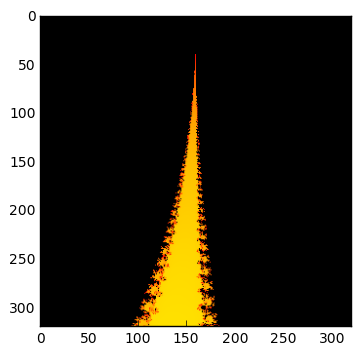

In [6]:
red = np.array([1, 0, 0])
blue = np.array([0, 0, 1])
yellow = np.array([1, 1, 0])
green = np.array([0, 1, 0])

m.reset_window()
lgr = LinearGradientRenderer(yellow, red, MAX_ITER)
m.set_window(-0.8, -0.7, 0, 0.1, reshape=True)
img = m.render(lgr)
plt.imshow(img)
plt.show()

In [7]:
cx = -0.761574
cy = -0.0847596 
out = 'test.gif'
zoom = 1.02
secs = 60
renderer = lgr
fps = 15
n = secs * fps

m.animate(cx, cy, zoom, n, renderer, out, fps=fps)